# Project Work, Part 3 - Data Quality
## 1. Introduction
This project involves analyzing data in a Jupyter Notebook and creating a multi-page online app with Streamlit, with all work and code shared on GitHub. AI tools (e.g., ChatGPT) were utilized during the project to clarify requirements and to gain a deeper understanding of the technologies used.

In [10]:
import requests 
import pandas as pd

In [3]:
import requests

headers = {    
    
}

endpoint = "https://api.elhub.no/energy-data/v0/"
entity = 'price-areas'
dataset = "PRODUCTION_PER_GROUP_MBA_HOUR"
#startdate = '2021-01-01T00:20:00%2B02:00'
#enddate = '2021-01-31T23:59:59%2B02:00'
year = 2021

In [6]:
import calendar
import pandas as pd

dates = []
# accessing the data for a month at a time as Endpoint does not allow us to get for a whole year.
for month in range(1, 13):
    # Get number of days in month
    _, last_day = calendar.monthrange(year, month)
    
    # Format month and day properly (e.g. 01, 02, …)
    startdate = f"{year}-{month:02d}-01T00:20:00%2B02:00"
    enddate = f"{year}-{month:02d}-{last_day:02d}T23:59:59%2B02:00"
    
    dates.append((startdate, enddate))

all_data = []

for startdate, enddate in dates:
    #print(f"Start: {start}   End: {end}")
    data = []
    response = requests.get(f"{endpoint}{entity}?dataset={dataset}&startDate={startdate}&endDate={enddate}", headers=headers)
    #print(response.status_code)
    data = response.json()
    #data['data'][1]['attributes']['productionPerGroupMbaHour']
    for i in data['data']:
        all_data.extend(i['attributes']['productionPerGroupMbaHour'])
elbub_df = pd.DataFrame(all_data)
print(elbub_df.shape)

(215059, 6)


In [8]:
elbub_df.columns

Index(['endTime', 'lastUpdatedTime', 'priceArea', 'productionGroup',
       'quantityKwh', 'startTime'],
      dtype='object')

In [16]:
data = {
    "priceArea": ["NO1", "NO2", "NO3", "NO4", "NO5"],
    "city": ["Oslo", "Kristiansand", "Trondheim", "Tromsø", "Bergen"],
    "latitude": [59.9127, 58.1467, 63.4305, 69.6489, 60.393],
    "longitude": [10.7461, 7.9956, 10.3951, 18.9551, 5.3242]
}

mapping_df = pd.DataFrame(data)
print(mapping_df)

  priceArea          city  latitude  longitude
0       NO1          Oslo   59.9127    10.7461
1       NO2  Kristiansand   58.1467     7.9956
2       NO3     Trondheim   63.4305    10.3951
3       NO4        Tromsø   69.6489    18.9551
4       NO5        Bergen   60.3930     5.3242


In [21]:
#merging two dataframe
production_df = pd.merge(elbub_df, mapping_df, on='priceArea', how='left')

# Parse and sort the time column
production_df['startTime'] = pd.to_datetime(production_df['startTime'])
merged_df = production_df.sort_values('startTime')

production_df.tail()

/var/folders/l6/vl95ck9n0xx9fv4qkcl03l_m0000gn/T/ipykernel_5689/4087155121.py:5: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  production_df['startTime'] = pd.to_datetime(production_df['startTime'])


,endTime,lastUpdatedTime,priceArea,productionGroup,quantityKwh,startTime,city,latitude,longitude
215054,2021-12-31T20:00:00+01:00,2024-10-27T07:56:27+01:00,NO5,wind,0.0,2021-12-31 19:00:00+01:00,Bergen,60.393,5.3242
215055,2021-12-31T21:00:00+01:00,2024-10-27T07:56:27+01:00,NO5,wind,0.0,2021-12-31 20:00:00+01:00,Bergen,60.393,5.3242
215056,2021-12-31T22:00:00+01:00,2024-10-27T07:56:27+01:00,NO5,wind,0.0,2021-12-31 21:00:00+01:00,Bergen,60.393,5.3242
215057,2021-12-31T23:00:00+01:00,2024-10-27T07:56:27+01:00,NO5,wind,0.0,2021-12-31 22:00:00+01:00,Bergen,60.393,5.3242
215058,2022-01-01T00:00:00+01:00,2024-10-27T07:56:27+01:00,NO5,wind,0.0,2021-12-31 23:00:00+01:00,Bergen,60.393,5.3242


In [65]:
def get_weather_data(lat, lon, year):
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": f"{year}-01-01",
        "end_date": f"{year}-12-31",
        "hourly": ["temperature_2m", "precipitation", "windspeed_10m", "wind_gusts_10m", "wind_direction_10m"],  # example variables
        "timezone": "Europe/Oslo"
    }
    response = requests.get(url, params=params)
    data = response.json()
    df = pd.DataFrame(data["hourly"])
    df = df.rename(columns={'temperature_2m': 'temperature_2m (°C)', 'windspeed_10m': 'wind_speed_10m (m/s)', 
                             'precipitation': 'precipitation (mm)','wind_gusts_10m': 'wind_gusts_10m (m/s)', 
                             'wind_direction_10m': 'wind_direction_10m (°)'})
    return df

bergen_lat = 60.39
bergen_lon = 5.32

df_bergen_2019 = get_weather_data(bergen_lat, bergen_lon, 2019)
df_bergen_2019.head()


,time,temperature_2m (°C),precipitation (mm),wind_speed_10m (m/s),wind_gusts_10m (m/s),wind_direction_10m (°)
0,2019-01-01T00:00,5.7,0.7,37.0,99.7,263
1,2019-01-01T01:00,5.8,0.2,41.0,107.3,278
2,2019-01-01T02:00,6.1,0.7,42.0,112.0,286
3,2019-01-01T03:00,6.3,0.5,40.9,105.8,298
4,2019-01-01T04:00,5.8,1.1,41.2,110.2,315


In [87]:
df_bergen_2019.shape

(8760, 6)

## Outliers and Anomalies:

### Plot the temperature as a function of time.

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct

def analyze_temperature_outliers(
    df,
    time_col='time',
    temp_col='temperature_2m (°C)',
    freq_cutoff=10, #Number of low-frequency DCT components to remove (default=10).
    k=3, #Number of robust standard deviations (MAD scaled) for SPC limits (default=3)

    #plot=True # Here we want plot by default, not an optional but it is nice to have optional with default value.
):
    """
    Returns
    outliers_df : DataFrame of outlier rows (with SATV column)
    stats : dict of summary statistics
    fig : matplotlib figure
    """

    # --- Prepare data ---
    data = df.copy() #This will speed up the plot process as it copy all data once and work with it
    data[time_col] = pd.to_datetime(data[time_col])
    data = data.sort_values(time_col).reset_index(drop=True)

    temps = data[temp_col].astype(float).values

    # --- DCT high-pass filter ---
    coeff = dct(temps, norm='ortho')
    highpass = np.copy(coeff)
    highpass[:freq_cutoff] = 0.0  # remove low-frequency (seasonal) components
    satv = idct(highpass, norm='ortho')  # Seasonally Adjusted Temperature Variations

    # --- Robust SPC limits ---
    median_satv = np.median(satv)
    mad_satv = np.median(np.abs(satv - median_satv))
    robust_sigma = 1.4826 * mad_satv  #(robust_sigma = 1.4826; For a formal data- lecture)
    upper = median_satv + k * robust_sigma
    lower = median_satv - k * robust_sigma

    # --- Identify outliers ---
    outlier_mask = (satv > upper) | (satv < lower)
    outliers_df = data.loc[outlier_mask].copy()
    outliers_df.loc[:, 'SATV'] = satv[outlier_mask]

    # --- Plot ---
    #fig = None
    #if plot:
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(data[time_col], temps, label='Temperature', color='orange', lw=1)
    ax.scatter(data.loc[outlier_mask, time_col],
                   temps[outlier_mask],
                   color='red', s=20, label='Outliers')

    # reference lines
    temp_median = np.median(temps)
    ax.axhline(temp_median, color='gray', linestyle='--', label='Median Temperature')
    ax.axhline(temp_median + upper, color='orange', linestyle='--', label='Upper SPC limit')
    ax.axhline(temp_median + lower, color='orange', linestyle='--', label='Lower SPC limit')

    ax.set_title("Temperature Outliers via DCT High-pass Filtering & Robust SPC")
    ax.set_xlabel("Time")
    ax.set_ylabel("Temperature (°C)")
    ax.legend()
    plt.tight_layout()

    # --- Summary ---
    stats = {
        'n_points': len(data),
        'n_outliers': int(outlier_mask.sum()),
        'proportion_outliers': float(outlier_mask.sum()) / len(data),
        'median_SATV': float(median_satv),
        'MAD_SATV': float(mad_satv),
        'robust_sigma': float(robust_sigma),
        'upper_limit_SATV': float(upper),
        'lower_limit_SATV': float(lower)
    }

    #if plot:
    return outliers_df, stats, fig
    #return outliers_df, stats

n_points:8760
n_outliers:139
proportion_outliers:0.015867579908675798
median_SATV:-0.26469996833870235
MAD_SATV:2.154906962579277
robust_sigma:3.1948650627200363
upper_limit_SATV:9.319895219821406
lower_limit_SATV:-9.84929515649881


,time,temperature_2m (°C),precipitation (mm),wind_speed_10m (m/s),wind_gusts_10m (m/s),wind_direction_10m (°),SATV
652,2019-01-28 04:00:00,-9.0,0.0,6.5,12.6,90,-11.075845
653,2019-01-28 05:00:00,-10.6,0.0,5.2,10.4,74,-12.678163
654,2019-01-28 06:00:00,-11.3,0.0,5.4,11.5,82,-13.380481
655,2019-01-28 07:00:00,-11.8,0.0,5.4,11.9,90,-13.882799
656,2019-01-28 08:00:00,-11.6,0.0,5.4,12.6,94,-13.685116


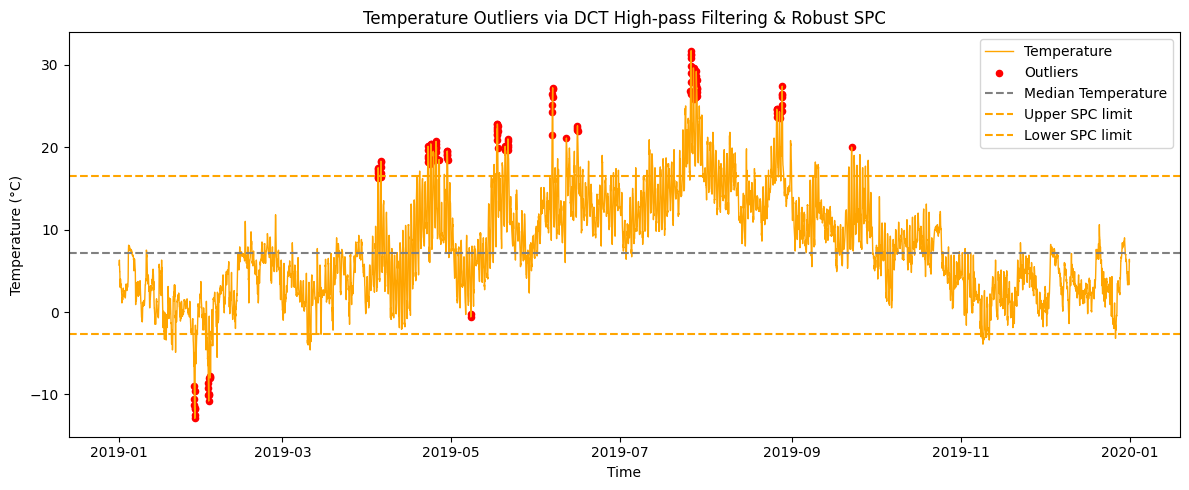

In [78]:
out_temp, stats_temp, fig_temp = analyze_temperature_outliers(df_bergen_2019)
for i in stats_temp:
    print(f"{i}:{stats_temp[i]}")
out_temp.head()

### Plot the precipitation as a function of time.

In [97]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import LocalOutlierFactor

def analyze_precipitation_anomalies(
    df,
    time_col='time', #Column name for timestamps
    precip_col='precipitation (mm)', #Column name for precipitation values
    proportion=0.01 #Expected proportion of anomalies (0-1); 1%
):
    """
    Returns
    outlier_df : DataFrame containing only the detected anomalies
    stats : Summary statistics about anomalies
    fig : matplotlib.figure.Figure
    """
    
    df = df.copy()
    df[time_col] = pd.to_datetime(df[time_col])
    df = df.sort_values(time_col).reset_index(drop=True)
    
    precip = df[precip_col].fillna(0).values.reshape(-1, 1)

    # --- Apply LOF (Local Outlier Factor) ---
    lof = LocalOutlierFactor(contamination=proportion)
    labels = lof.fit_predict(precip)
    mask = labels == -1  # -1 means anomaly (outlier)
    
    # Extract anomalies
    outlier_df = df[mask].copy()
    outlier_df['LOF_Score'] = lof.negative_outlier_factor_[mask]

    # --- Plot ---
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(df[time_col], df[precip_col], label='Precipitation', color='blue')
    ax.scatter(df.loc[mask, time_col], df.loc[mask, precip_col],
                   color='red', label='Anomalies (LOF)', zorder=3)
    ax.set_title("Precipitation Anomalies via Local Outlier Factor")
    ax.set_xlabel("Time")
    ax.set_ylabel("Precipitation (mm)")
    ax.legend()
    plt.tight_layout()

    # --- Summary Statistics ---
    stats = {
        'n_points': len(df),
        'n_anomalies': len(outlier_df),
        'proportion_anomalies': round(len(outlier_df) / len(df), 4),
        'mean_precipitation': df[precip_col].mean(),
        'mean_anomalies': outlier_df[precip_col].mean() if len(outlier_df) > 0 else None
    }

    # --- Return Results ---
    return outlier_df, stats, fig

n_points:8760
n_anomalies:80
proportion_anomalies:0.0091
mean_precipitation:0.24651826484018266
mean_anomalies:3.5387499999999994


,time,temperature_2m (°C),precipitation (mm),wind_speed_10m (m/s),wind_gusts_10m (m/s),wind_direction_10m (°),LOF_Score
86,2019-01-04 14:00:00,7.9,2.4,16.6,45.0,304,-1.000000e+00
88,2019-01-04 16:00:00,8.0,2.3,18.0,47.2,323,-1.000000e+08
477,2019-01-20 21:00:00,1.3,3.8,21.0,54.4,158,-1.070580e+00
1026,2019-02-12 18:00:00,4.3,3.3,19.0,53.3,161,-1.201389e+00
1227,2019-02-21 03:00:00,6.3,2.4,15.0,42.8,159,-1.000000e+00


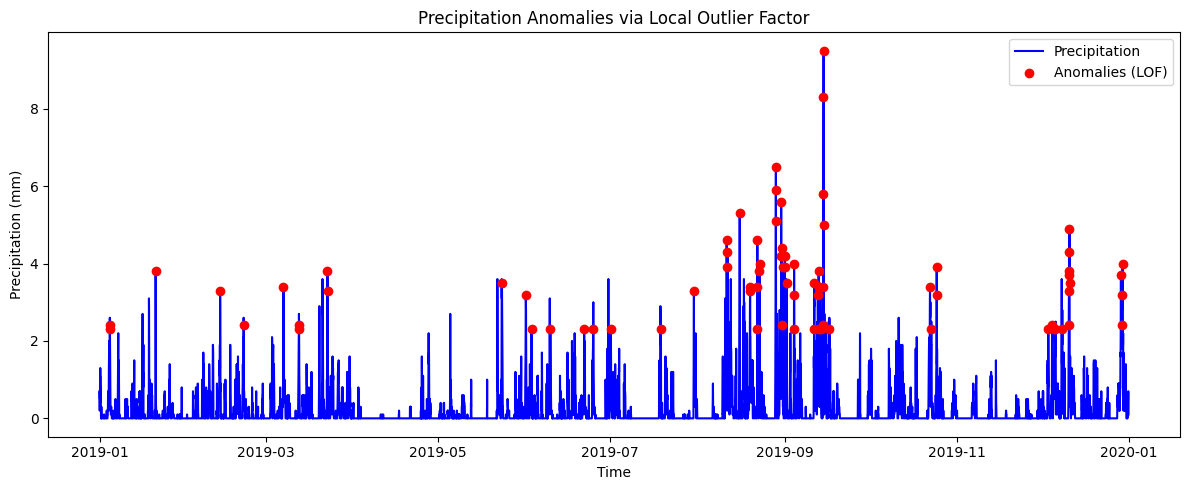

In [98]:
out_precip, stats_precip, fig_precip = analyze_precipitation_anomalies(df_bergen_2019)
for i in stats_precip:
    print(f"{i}:{stats_precip[i]}")
out_precip.head()

### Seasonal-Trend decomposition using LOESS (STL)

In [53]:
production_df.head(2)

,endTime,lastUpdatedTime,priceArea,productionGroup,quantityKwh,startTime,city,latitude,longitude
0,2021-01-01T02:00:00+01:00,2024-12-20T10:35:40+01:00,NO1,hydro,2494728.0,2021-01-01 01:00:00+01:00,Oslo,59.9127,10.7461
1,2021-01-01T03:00:00+01:00,2024-12-20T10:35:40+01:00,NO1,hydro,2486777.5,2021-01-01 02:00:00+01:00,Oslo,59.9127,10.7461


In [63]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

def stl_decomposition_by_area(
    production_df,
    city='Oslo',
    group='wind',
    time_col='startTime',
    value_col='quantityKwh',
    period=24,
    seasonal=12,
    trend=365,
    robust=True,
    plot=True
):
    """
    Perform STL decomposition for a specific price area and production group.

    Parameters
    ----------
    df : merged DataFrame with price_area, production_group and time/value cols
    area : str, price area code (e.g., 'NO1')
    group : str, production group (e.g., 'hydro', 'wind', 'total')
    period : int, number of time steps per seasonal cycle
    seasonal : int, smoothness for seasonal component
    trend : int, smoothness for long-term trend
    robust : bool, make LOESS robust to outliers
    plot : bool, show STL plot if True

    Returns
    -------
    result : STL decomposition object
    fig : matplotlib figure (if plot=True)
    """

    # Subset data
    sub = production_df[(production_df['city'] == city) &
             (production_df['productionGroup'].str.lower() == group.lower())].copy()

    # Sort and check
    sub = sub.sort_values(time_col)
    sub[time_col] = pd.to_datetime(sub[time_col],utc=True)
    sub = sub.set_index(time_col)

    # Perform STL
    stl = STL(
        sub[value_col],
        period=period,
        seasonal=seasonal,
        trend=trend,
        robust=robust
    )
    result = stl.fit()

    fig = None
    if plot:
        fig = result.plot()
        fig.set_size_inches(10, 7)
        plt.suptitle(f"STL Decomposition — {city} ({group.title()})", fontsize=14)
        plt.tight_layout(rect=[0, 0, 1, 0.95])

    return result, fig

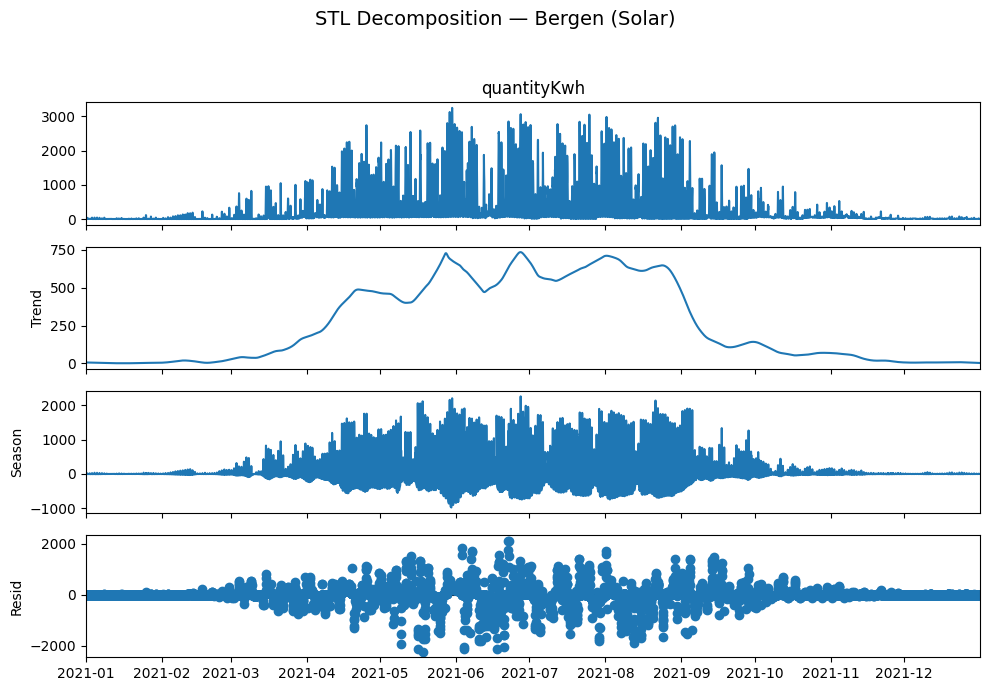

In [67]:
result, fig = stl_decomposition_by_area(
    production_df,  # from your earlier part of the project
    time_col='startTime',
    value_col='quantityKwh',
    city='Bergen',
    group='solar',
    period=24,       # daily cycle
    seasonal=5,     # seasonal smoothing
    trend=365,       # yearly smooth trend
    robust=True
)

# You can access components as:
trend = result.trend
seasonal = result.seasonal
resid = result.resid